In [1]:
#import serial
#import time
#ser = serial.Serial('/dev/tty.hirojiren-SerialPortPro', 115200, timeout=None)



In [2]:
#ser.write(b"1")
##time.sleep(0.2)
#line = ser.read(2)
#print(line)

In [3]:
#ser.write(b"3")
#line = ser.read(20)
#print(line)

In [4]:
#ser.close()

In [5]:
import image_processing
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [6]:
IMAGE_DIR   = "image_fukuyama/"
image_list = image_processing.load_image_set(IMAGE_DIR)
image = image_list[1]



In [7]:
img_psp = image_processing.persipective_image(image)
masked_image = image_processing.masked_image(img_psp)
block_img = []
num_img, block_img = image_processing.triming_image(masked_image)

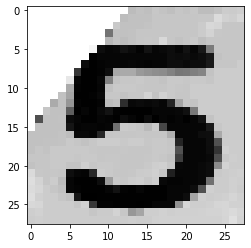

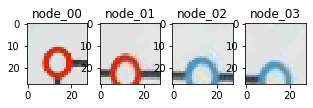

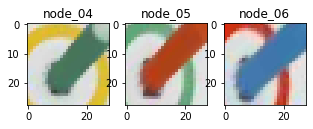

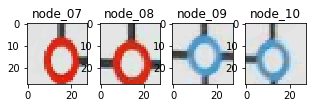

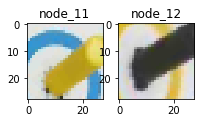

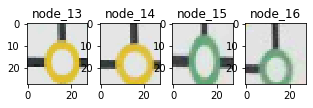

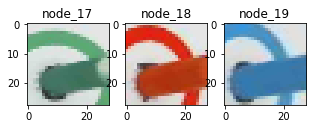

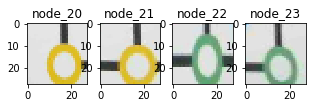

In [9]:
#plot triming and standardized image
plt.imshow(num_img, plt.cm.gray)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(5,5))
ax1.set_title('node_00')
ax1.imshow(block_img[0])
ax2.set_title('node_01')
ax2.imshow(block_img[1])
ax3.set_title('node_02')
ax3.imshow(block_img[2])
ax4.set_title('node_03')
ax4.imshow(block_img[3])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5,5))
ax1.set_title('node_04')
ax1.imshow(block_img[4])
ax2.set_title('node_05')
ax2.imshow(block_img[5])
ax3.set_title('node_06')
ax3.imshow(block_img[6])

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(5,5))
ax1.set_title('node_07')
ax1.imshow(block_img[7])
ax2.set_title('node_08')
ax2.imshow(block_img[8])
ax3.set_title('node_09')
ax3.imshow(block_img[9])
ax4.set_title('node_10')
ax4.imshow(block_img[10])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(3,3))
ax1.set_title('node_11')
ax1.imshow(block_img[11])
ax2.set_title('node_12')
ax2.imshow(block_img[12])

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(5,5))
ax1.set_title('node_13')
ax1.imshow(block_img[13])
ax2.set_title('node_14')
ax2.imshow(block_img[14])
ax3.set_title('node_15')
ax3.imshow(block_img[15])
ax4.set_title('node_16')
ax4.imshow(block_img[16])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5,5))
ax1.set_title('node_17')
ax1.imshow(block_img[17])
ax2.set_title('node_18')
ax2.imshow(block_img[18])
ax3.set_title('node_19')
ax3.imshow(block_img[19])

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(5,5))
ax1.set_title('node_20')
ax1.imshow(block_img[20])
ax2.set_title('node_21')
ax2.imshow(block_img[21])
ax3.set_title('node_22')
ax3.imshow(block_img[22])
ax4.set_title('node_23')
ax4.imshow(block_img[23])